# Demo

Demo Description

## Designing the image processing pipeline

Data are acquired by an USB Camera, elaborated by the PYNQ board and shown to an HDMI Monitor.
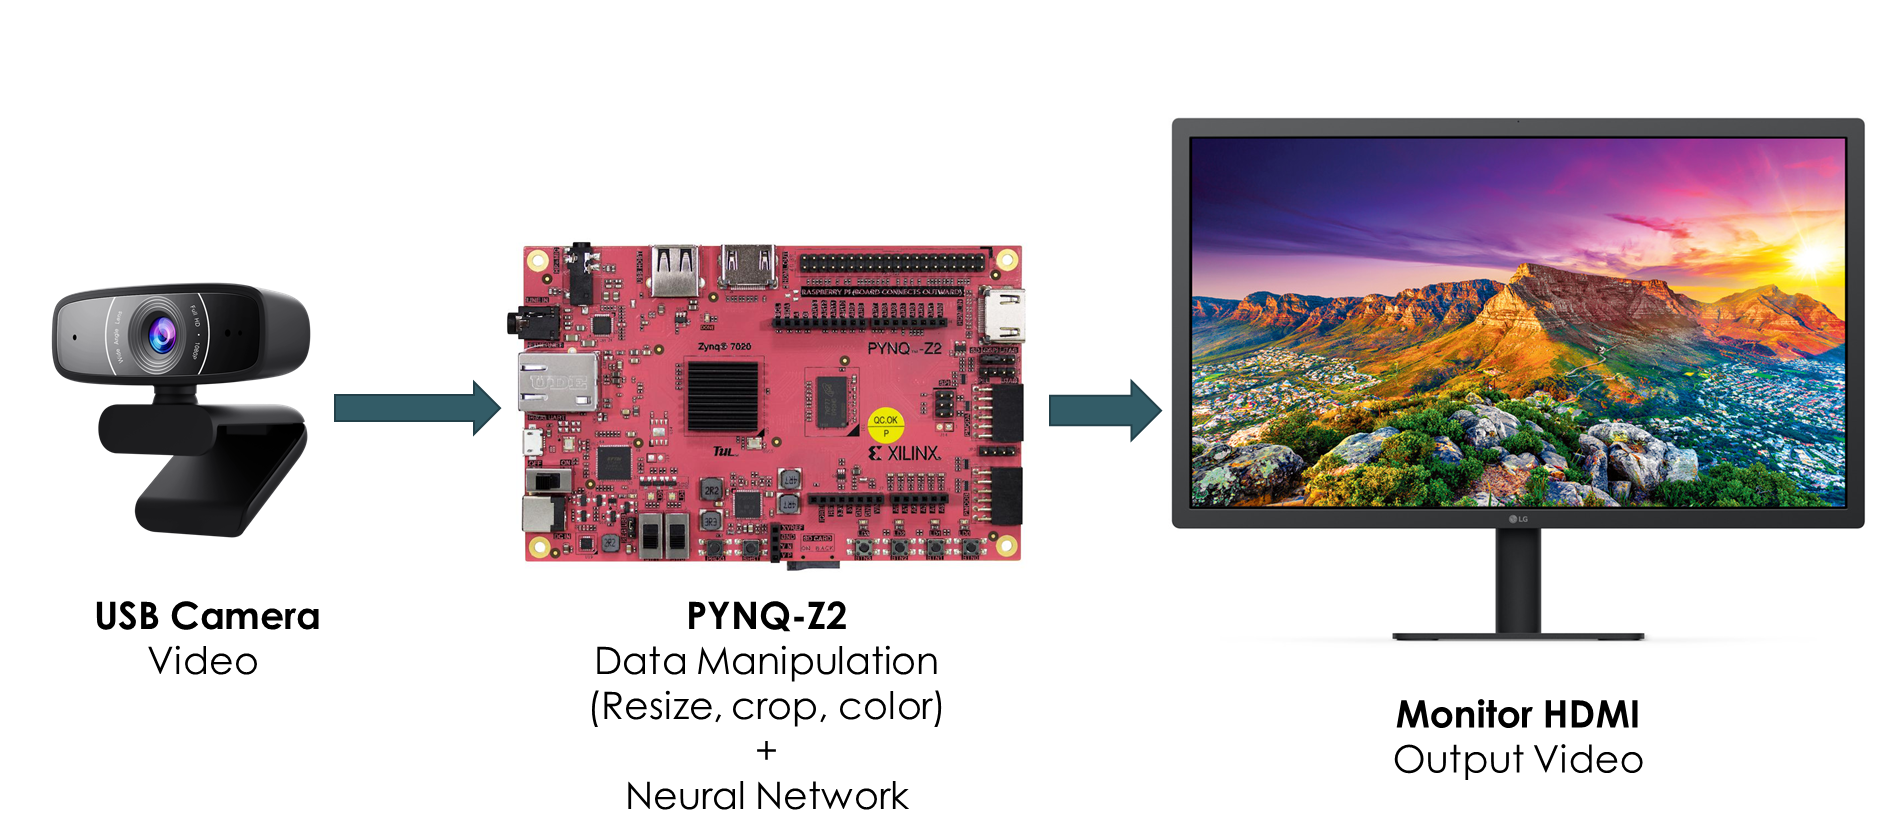

#### USB Input
The USB controller is capable of fulfilling a wide range of applications for USB 2.0 implementations as a host, a device, or On-the-Go. Two identical controllers are in the Zynq-7000 device. Each controller is configured and controlled independently. The USB controller I/O uses the ULPI protocol to connect external ULPI PHY via the MIO pins. The ULPI interface provides an 8-bit parallel SDR data path from the controller’s internal UTMI-like bus to the PHY. The ULPI interface minimizes device pin count and is controlled by a 60 MHz clock output from the PHY. [Ref. https://xilinx-wiki.atlassian.net/wiki/spaces/A/pages/18842272/Zynq+Linux+USB+Device+Driver]

#### Data Path
The PYNQ-Z2 board has 512 MB external DDR memory connected to a DDR memory controller in the Zynq PS. There is a direct path from the PL to DDR memory.
The base overlay also supports writing to three framebuffers in DDR memory. Double buffering and triple buffering are common techniques for smooth display of graphics, and can be used with the base overlay.

The USB input controller can stream data to DDR memory for image capture using a DMA. Similarly, the HDMI output can stream data from DDR memory for output display using a seperate DMA.

From a top level perspective, the image processing pipeline involves sending data to the resize IP accelerator and the NN via the DMA and reading back data. In essence we have a loop back setup between the DMA and PS DDR memroy with the accelerator in the middle. The DMA has to be configured with a read and a write channel.
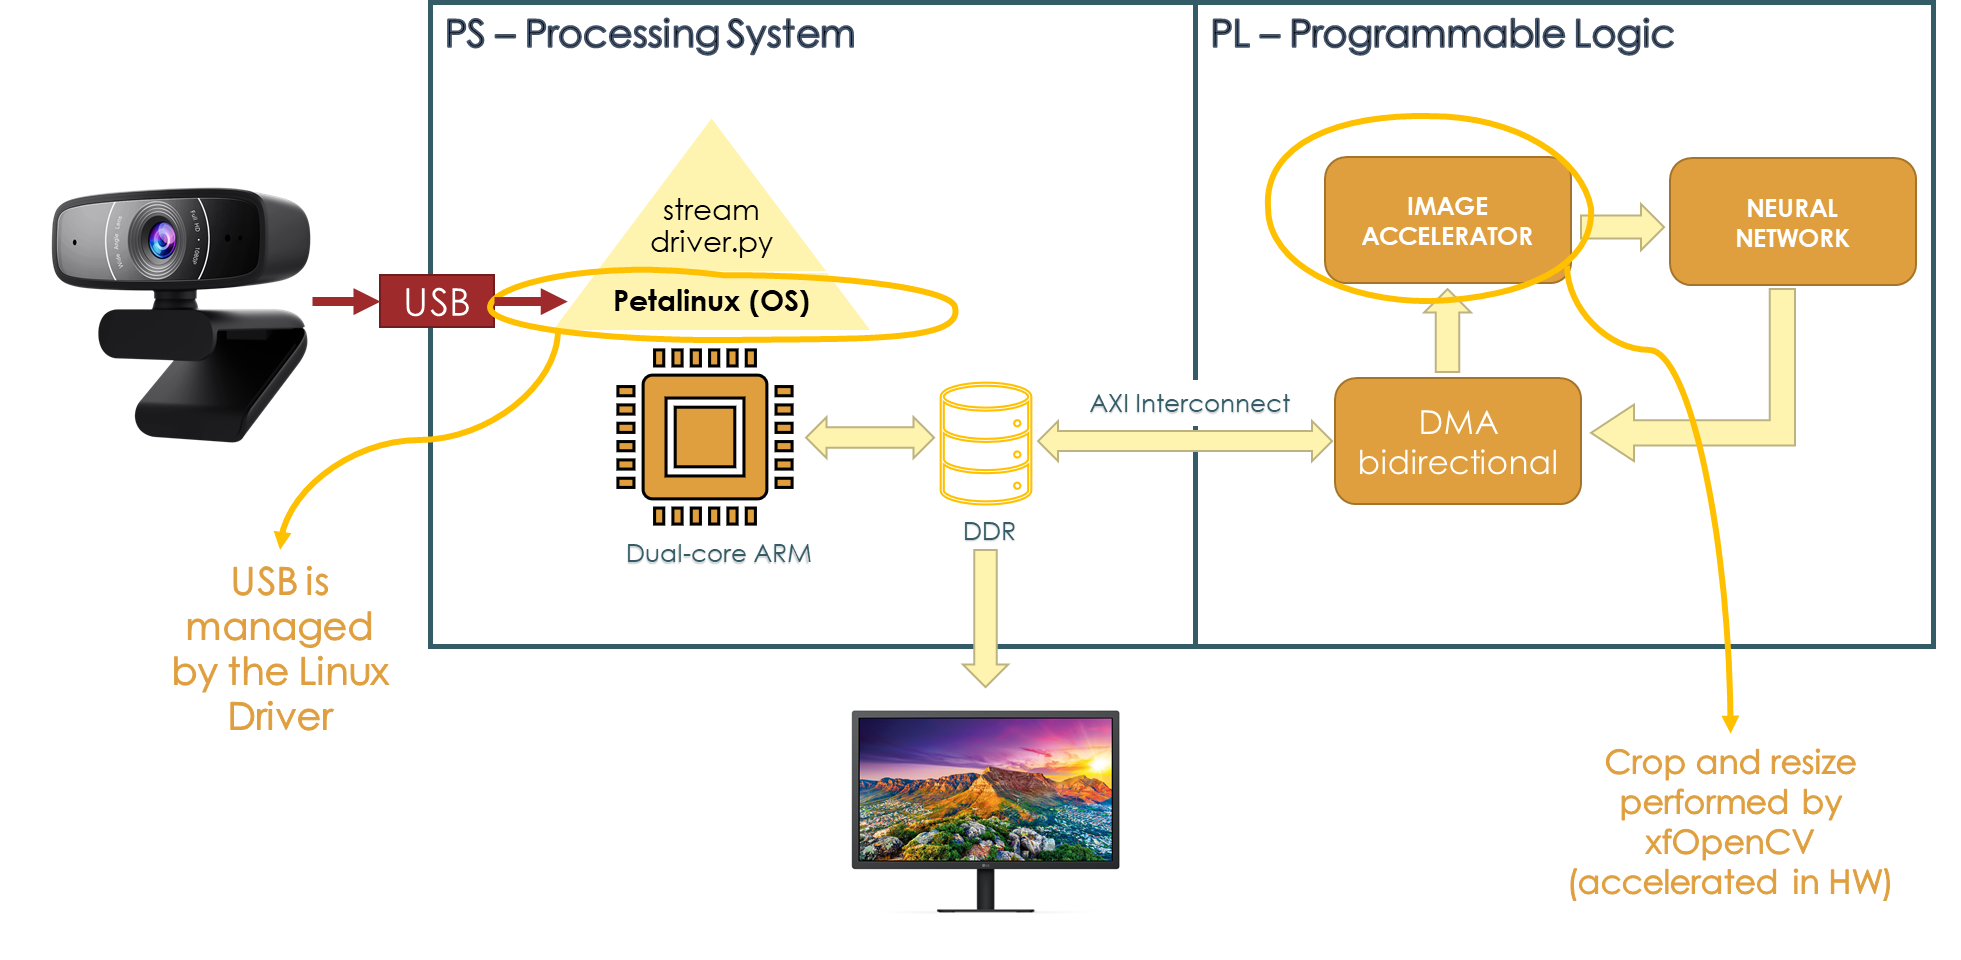

### Set up the board:
Download the base overlay:

In [1]:
from pynq.overlays.base import BaseOverlay
from pynq.lib.video import *
base = BaseOverlay("base.bit")

Set the HDMI output mode to 640 x 480 and start HDMI output:

In [9]:
# monitor configuration: 640*480 @ 60Hz
Mode = VideoMode(640,480,24)
hdmi_out = base.video.hdmi_out
hdmi_out.configure(Mode,PIXEL_BGR)
hdmi_out.start()

Define some constants for the input (webcam) and output (HDMI output) frame sizes.

In [10]:
# monitor (output) frame buffer size
#frame_out_w = 1920
#frame_out_h = 1080

frame_out_w = 32
frame_out_h = 32


# camera (input) configuration
frame_in_w = 640
frame_in_h = 480

All PYNQ releases ship with the popular OpenCV library pre-installed. The PYNQ computer vision overlays enable accelerating OpenCV components in Programmable Logic (PL). These overlays expose a subset Xilinx' xfOpenCV library (a part of Xilinx' reVISION solution) at the Python level, combined with the support for HDMI input/output. Webcam, stream or file based input/output remains available through the pre-installed SW OpenCV.[Ref: https://github.com/Xilinx/PYNQ-ComputerVision]

In [13]:
# initialize camera from OpenCV
import cv2 as cv

videoIn = cv.VideoCapture(-1)
videoIn.set(cv.CAP_PROP_FRAME_WIDTH, frame_in_w);
videoIn.set(cv.CAP_PROP_FRAME_HEIGHT, frame_in_h);

print("Capture device is open: " + str(videoIn.isOpened()))

Capture device is open: True


In [14]:
ret, frame = videoIn.read()
frame_w = frame.shape[1]
frame_h = frame.shape[0]
print("Webcam resolution: ", frame_w, "x", frame_h)


Webcam resolution:  640 x 480


In [21]:
# Capture webcam video and display to HDMI Output
#import numpy as np
import time
start = time.time()
for NumOfFrames in range (100): 
    ret, frame = videoIn.read()
    if (ret):
        outframe = hdmi_out.newframe()
        crop_frame = frame[0:32, 0:32]
        #outframe[0:480,0:640,:] = frame[0:480,0:640,:]
        outframe[0:32,0:32,:] = crop_frame[0:32,0:32,:]
        hdmi_out.writeframe(outframe)
    else:
        raise RuntimeError("Failed to read from camera.")
end = time.time()
print("Frames per second:     " + str(50 / (end - start)))

Frames per second:     6.52128823951475


In [7]:
videoIn.release()
#hdmi_out.stop()
#del hdmi_out, frame

### Change Resolution
Change the webcam resolution to 1280 x 800 and repeat the frame streaming

In [ ]:
# camera (input) configuration
frame_in_w = 1280
frame_in_h = 720

# initialize camera from OpenCV
videoIn = cv2.VideoCapture(-1)
videoIn.set(cv2.CAP_PROP_FRAME_WIDTH, frame_in_w);
videoIn.set(cv2.CAP_PROP_FRAME_HEIGHT, frame_in_h);
print("capture device is open: " + str(videoIn.isOpened()))

In [ ]:
# check input resolution
ret, frame = videoIn.read()
frame_w = frame.shape[1]
frame_h = frame.shape[0]
print("Webcam Resolution:", frame_w, "x", frame_h)

In [ ]:
start = time.time()
for NumOfFrames in range (50):
    # read next image
    ret, frame = videoIn.read()
    frame.resize(frame_w*frame_h*3)
    
    if (ret):
        outframe = hdmi_out.newframe()
        for y in range (frame_h):
            #outframe[0:480,0:640,:] = frame_webcam[0:480,0:640,:]
            outframe[y*frame_out_w*3:y*frame_out_w*3+frame_w*3] = frame.data[y*frame_w*3:(y+1)*frame_w*3]
        # copy to frame buffer / show on monitor
        hdmi_out.writeframe(outframe)   
    else:
        readError = readError + 1

end = time.time()
print("Frames per second:     " + str(50 / (end - start)))

### Display image on notebook

In [ ]:
# Output webcam image as JPEG
%matplotlib inline 
from matplotlib import pyplot as plt
import numpy as np
plt.imshow(frame[:,:,[2,1,0]])
plt.show()

### Image captured using fswebcam
A generic USB camera can then be lugged into the USB hub and this will enumerate as a /video device under /dev folder on PYNQ distro as shown below.

In [ ]:
from PIL import Image as PIL_Image

orig_img_path = '/home/xilinx/webcam.jpg'
!fswebcam  --no-banner --save {orig_img_path} -d /dev/video0 2> /dev/null

img = PIL_Image.open('/home/xilinx/webcam.jpg')
img